In [124]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

In [125]:
# Initialize arrays to save the file data
att_to = []
date_time = []
first_time = []
source = []

# Open the input file
input_file = open( "pings.txt", 'r')

for line_number,line in enumerate( input_file ):
    # convert string to json
    line_json = json.loads( line )
    
    # If the source is absent from the json set it to Unknown
    if 'first_utm_source' not in line_json:
        line_json[ 'first_utm_source' ] = 'Unknown'
    # Add the json data to the arrays.
    att_to.append( line_json[ 'attributed_to' ] )
    date_time.append( line_json[ 'date_time' ] )
    first_time.append( line_json[ 'used_first_time_today' ] )
    source.append( line_json[ 'first_utm_source' ] )

# Create the pandas datafram from the file data.
input_data = pd.DataFrame( { 'att_to': att_to, 'date_time': date_time, 'first_time': first_time, 'source':source } ) 

# Convert the date_time array to python datetime object
input_data[ 'date_time' ] = pd.to_datetime( input_data[ 'date_time' ] )
input_data.head()


,att_to,date_time,first_time,source
0,u:1725355044,2016-02-01,False,brand1
1,u:-1639496947,2016-02-01,False,google
2,u:-933156145,2016-02-01,False,Unknown
3,f:-897928592,2016-02-01,False,Unknown
4,u:-870925480,2016-02-01,False,google


**Calculate the daily retention curve for users who used the app for the first time on the following dates: Feb 4th, and Feb 10th.**

In [126]:
# Filter for users who used the app for the first time on Feb 4th and Feb 10th.
user_set = input_data[ ( input_data[ 'first_time'] == 1 ) & ( input_data[ 'date_time' ].dt.day.isin( [ 4,10 ] ) )
                         & ( input_data[ 'date_time' ].dt.month == 2 ) ]

# Count of the number of users in the filtered list.
user_count = len( user_set.groupby('att_to') )

# Doing a join of the data sets input_data and user_set so that we filter the data for the users in the user_set
Merged_data = pd.merge( input_data, user_set, on=['att_to' ] ) 


# Using groupby to get the number of distinct users who logged in on each day.
Merged_data_group = Merged_data.groupby( [ Merged_data.date_time_x.dt.year, Merged_data.date_time_x.dt.month, 
                          Merged_data.date_time_x.dt.day ] ).att_to.nunique()

# Extract the list of all the days for which we extracted the counts
dates =  list( Merged_data_group.index.levels[ 2 ] )

# Convert the count to a percentage scale by dividing with user_count
vistor_count_scaled = [ float(x)/user_count*100 for x in list( Merged_data_group.values ) ]

# Calculate mean and std deviation of the percentage vistor_count.
mean_all = np.mean( vistor_count_scaled )
std_dev_all = np.std( vistor_count_scaled )

(0, 110)

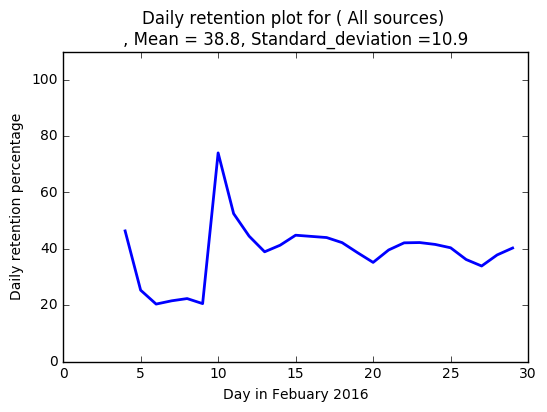

In [127]:
# Daily retention curve.
plt.xlabel('Day in Febuary 2016')
plt.ylabel('Daily retention percentage')
plt.title('Daily retention plot for ( All sources) \n, Mean = ' + str( mean_all)[ :4 ]
              + ", Standard_deviation =" + str( std_dev_all)[ :4 ] )
plt.plot(dates, vistor_count_scaled, lw=2)
plt.ylim((0,110))

In [83]:
def plot_daily_retention_source( input_data, source_name, date_vals, plot = True ):
    ''' This function can plot the daily retention curve or return the mean retention value for a specific source 
    and for users who first appeared on a specific dates.
    '''
    
    # Filter for users who used the app for the first time on dates specified by date_vals and 
    # have the given source_name.
    user_set_source = input_data[ ( input_data[ 'first_time'] == True ) & ( input_data[ 'source' ] == source_name ) 
                                & ( input_data[ 'date_time' ].dt.day.isin( date_vals ) ) ]
    # Count of the number of users in the filtered list.
    user_count_source = len( user_set_source.groupby('att_to') )
    # Doing a join of the data sets input_data and user_set_source so that we filter 
    # the data for the users in the user_set_source
    merged_data_source = pd.merge( input_data, user_set_source, on=['att_to' ] )
    
    # In case the merge ends up empty return the mean to be zero.
    if len( merged_data_source ) == 0:
        return 0
    
    # Using groupby to get the number of distinct users who logged in on each day.
    merged_data_group_source = merged_data_source.groupby( [ merged_data_source.date_time_x.dt.year, 
                                                     merged_data_source.date_time_x.dt.month, 
                              merged_data_source.date_time_x.dt.day ] ).att_to.nunique()
    
    # Extract the list of all the days for which we extracted the counts
    dates_source =  list( merged_data_group_source.index.levels[ 2 ] )
    
    # Convert the count to a percentage scale by dividing with user_count_source
    vistor_count_scaled_source = [ float(x)/user_count_source*100 for x in list( merged_data_group_source.values ) ]
    
    # Calculate mean and std deviation of the percentage vistor_count_scaled_source.
    mean_source = np.mean( vistor_count_scaled_source )
    std_dev_source = np.std( vistor_count_scaled_source )
    
    # Depending on the plot parameter either plot the daily retention curve or return the mean value.
    if plot == True:
        # Daily retention curve.
        plt.xlabel('Day in Febuary 2016')
        plt.ylabel('Daily retention percentage')
        plt.title('Daily retention plot for ' + source_name + "\n, Mean = " + str( mean_source)[ :4 ]
                  + ", Standard_deviation =" + str( std_dev_source)[ :4 ] )
        plt.plot( dates_source, vistor_count_scaled_source, lw=2)
        plt.ylim((0,110))
    else:
        return mean_source
        

**Determine if there are any differences in usage based on where the users came from. 
From which traffic source does the app get its best users? its worst users?**

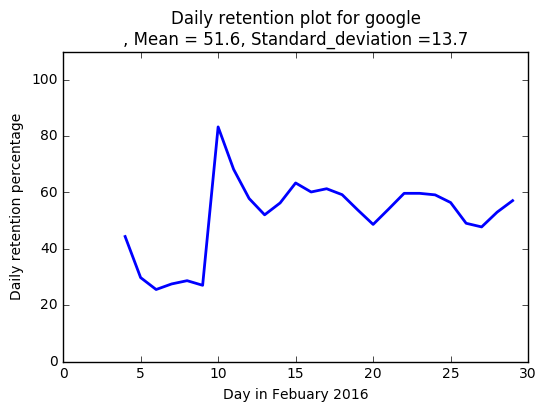

In [130]:
# For checking the usage based on source, I have written the function plot_daily_retention_source above.
# The retention curves are sensitive to the first apperance dates specified. 
# If I use the date values specified in the first question. I can initialize the date range as follows.
date_range = [ 4,10 ]

# Plotting the curves for different sources to see the variations.
plot_daily_retention_source( input_data, 'google', date_range )

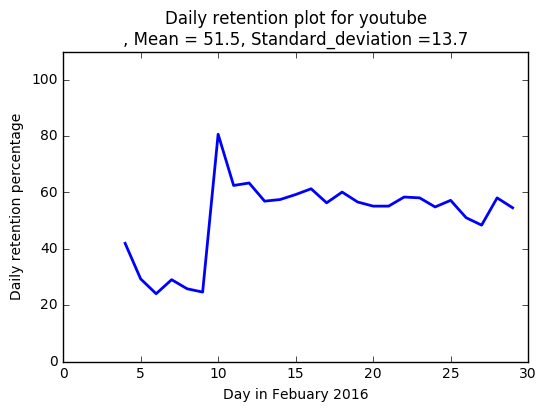

In [132]:
plot_daily_retention_source( input_data, 'youtube', date_range )

In [133]:
# Now in order to find out the best and worst sources, I can use the mean of the retention curves.
# Getting an exhaustive list of all sources 
source_list = list( input_data[ 'source' ].value_counts().index )
mean_dict = {}

# Iterating over each source and calculating the mean.
for source in source_list:
    mean_dict[ source ] = plot_daily_retention_source( input_data, source, date_range, False )

In [143]:
# Print out the sources ordered by Mean Retention Value
pd.DataFrame(mean_dict.items(), columns=['Source', 'Mean Retention Value']).sort_values( 
    by = ['Mean Retention Value' ], ascending = False)

,Source,Mean Retention Value
3,twitter,100.000000
24,"[brand1,+brand1]",100.000000
26,Facebook_org,78.260870
14,outbrain,69.230769
19,handbook,68.269231
51,pandora,67.200000
29,answers,65.000000
46,display,56.410256
41,placement,54.675716
20,taboola,54.431438


In [144]:
# Just for curiosity we can use dates different from the first question to analyze the quality of sources. 
# Lets say I chose to use the all the dates from Feb.
date_range = [ x for x in range( 1, 30 ) ]
mean_dict = {}

# Iterating over each source and calculating the mean.
for source in source_list:
    mean_dict[ source ] = plot_daily_retention_source( input_data, source, date_range, False )

# Print out the sources ordered by Mean Retention Value
pd.DataFrame(mean_dict.items(), columns=['Source', 'Mean Retention Value']).sort_values( 
    by = ['Mean Retention Value' ], ascending = False)

,Source,Mean Retention Value
40,shmoop_right,100.000000
21,Twitter_org,100.000000
35,MosaLingua+FR,100.000000
31,liveintent,100.000000
30,Blog_org,100.000000
27,tapjoy,100.000000
52,"[brand1, brand1]",100.000000
25,brand1BlogNL,100.000000
23,Bing,100.000000
49,shmoop_left,100.000000


 **Separate from the data analysis, it would be great to hear your thoughts on the Grammarly product and what data-related projects/ideas you think we should be pursuing. **

1) Studying user behavior in different environments.( Mac vs Windows, Chrome vs Firefox etc. ) - It is interesting to note that the ratings for Grammarly in Chrome ( 4.5/5 - https://chrome.google.com/webstore/detail/grammarly-for-chrome/kbfnbcaeplbcioakkpcpgfkobkghlhen?hl=en ) is much better than Firefox ( 3/5 - https://addons.mozilla.org/en-US/firefox/addon/grammarly-1/ ). Analysis of customer behavior could give us key insights. 

2) Studying customer acquisition cost vs customer lifetime value from various sources. This would give insights into how to most efficiently invest marketing money. This study can improve the return on investing in marketing by distributing the money in an optimal fashion. 

3) Having a champion/challenger system to roll out experimental updates - Before pushing out an experimental code update ( challenger ) to all users, first push it only to a fraction of the users and then observe the performance metrics on that subset. Depending on the performance metrics, we can decide on the future of the code updates.